In [1]:
from utils import parse_annotation, calculate_IoU, Object, Annotation
import collections
import os
import matplotlib.pyplot as plt
import numpy as np
from pyclustering.cluster.kmeans import kmeans as KMeans
from pyclustering.utils.metric import type_metric, distance_metric
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer, random_center_initializer
import time

In [2]:
#TODO: read from a config
input_width = 416
input_height = 416

grid_width = 13
grid_height = 13

In [3]:
path = '.\VOCdevkit\VOC2007\Annotations'

files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path):
    for file in f:
        if '.xml' in file:
            files.append(os.path.join(r, file))
            
#files = files[:500]

annotations = [parse_annotation(file) for file in files]

In [4]:
def distance(boxcoords, centroid):
    if boxcoords.ndim > 1:        
        result = []
        
        for i in range(len(boxcoords)):
            result.append(distance(boxcoords[i], centroid[i]))
            
        return result
    
    box = Object(xmin = 0, xmax = boxcoords[0], ymin = 0, ymax = boxcoords[1])    
    
    centroid_box = Object(xmin = 0, xmax = centroid[0], ymin = 0, ymax = centroid[1])    
    
    return 1 - calculate_IoU(box, centroid_box)

        
def find_anchor_boxes(kmeans_values, n_boxes):    
    initial_centers = kmeans_plusplus_initializer(kmeans_values, n_boxes).initialize()

    metric = distance_metric(type_metric.USER_DEFINED, func=distance)
    
    kmeans = KMeans(n_clusters = n_boxes, data = kmeans_values, initial_centers = initial_centers, metric = metric)
    
    kmeans.process()
    
    centers = kmeans.get_centers()
    clusters = kmeans.get_clusters()
    
    centers.sort(key = lambda c: c[0])
    
    return centers, clusters
    
kmeans_values = []
for annotation in annotations:
    cell_width = annotation.imagewidth / grid_width
    cell_height = annotation.imageheight / grid_height
    
    for obj in annotation.objects:
        width = (obj.xmax - obj.xmin) / cell_width
        height = (obj.ymax - obj.ymin) / cell_height
        

        kmeans_values.append(np.array([width, height]))
    
#centers, clusters = find_anchor_boxes(kmeans_values, 5)

In [5]:
def get_average_IoU(kmeans_values, centers):
    max_IoUs = []
    
    for obj in kmeans_values:
        IoUs = []
        for center in centers:
            current_IoU = 1 - distance(obj, center)
            IoUs.append(current_IoU)

        max_IoU = max(IoUs)
        max_IoUs.append(max_IoU)

    average_IoU = sum(max_IoUs) / len(max_IoUs)
    
    return average_IoU

In [6]:
start = time.time()
centers, clusters = find_anchor_boxes(kmeans_values, 5)
end = time.time()
print(f'Ran KMeans in {(end - start):.2f}s')

start = time.time()
average_IoU = get_average_IoU(kmeans_values, centers)
end = time.time()
print(f'Calculated average IoU in {(end - start):.2f}s')

print(average_IoU)
print(centers)

Ran KMeans in 20.22s
Calculated average IoU in 0.60s
0.6797388011934754
[[1.0561660983443226, 1.6511904188497952], [2.449072395202614, 4.138207169844389], [4.015072583065144, 8.458142650321642], [7.625899073003253, 5.13354454662471], [9.966163791780845, 10.43847889285282]]


For 1 clusters: Average IoU: 0.38092744980004206, ran KMeans in: 0.60s
For 2 clusters: Average IoU: 0.5494862760887055, ran KMeans in: 3.56s
For 3 clusters: Average IoU: 0.6218055697268634, ran KMeans in: 10.21s
For 4 clusters: Average IoU: 0.655789942196804, ran KMeans in: 24.44s
For 5 clusters: Average IoU: 0.6797308964404609, ran KMeans in: 18.76s
For 6 clusters: Average IoU: 0.7002586680303172, ran KMeans in: 26.08s
For 7 clusters: Average IoU: 0.7170832548468508, ran KMeans in: 74.82s
For 8 clusters: Average IoU: 0.7307393925275367, ran KMeans in: 63.20s
For 9 clusters: Average IoU: 0.7382479650403765, ran KMeans in: 51.37s
For 10 clusters: Average IoU: 0.7481120937942609, ran KMeans in: 64.36s
For 11 clusters: Average IoU: 0.7577966057951996, ran KMeans in: 64.04s
For 12 clusters: Average IoU: 0.7678862418164123, ran KMeans in: 180.34s
For 13 clusters: Average IoU: 0.7749085330699308, ran KMeans in: 98.77s
For 14 clusters: Average IoU: 0.7819683557179097, ran KMeans in: 143.50s
F

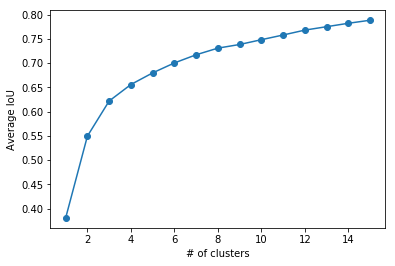

In [7]:
ks = []
anchors = []
IoUs = []
for k in range(1, 16):   
    start = time.time()
    
    ks.append(k)
    
    centers, clusters = find_anchor_boxes(kmeans_values, k)
    anchors.append(centers)
    average_IoU = get_average_IoU(kmeans_values, centers)
    IoUs.append(average_IoU)
    
    end = time.time()
    print(f'For {k} clusters: Average IoU: {average_IoU}, ran KMeans in: {(end - start):.2f}s')
    
plt.plot(ks, IoUs, marker='o')
plt.xlabel('# of clusters')
plt.ylabel('Average IoU')
plt.show()

In [8]:
for i in range(len(anchors)):
    print(ks[i])
    print(anchors[i])
    print()

1
[[3.9109038539073624, 5.0497244592197]]

2
[[1.6678269524872724, 2.7699283155704326], [7.145929311763909, 8.337707389612968]]

3
[[1.2721835071064291, 2.1051316862685314], [3.6827682837152405, 5.9644845569475375], [9.24469256121513, 9.360085847758503]]

4
[[1.0955005362957848, 1.85567691329724], [3.124482633475059, 4.35870705440147], [4.668559050552804, 8.409659593541031], [10.176966263881353, 9.400577118591759]]

5
[[1.0561660983443226, 1.6511904188497952], [2.4490013672877278, 4.139041510050218], [4.019226309147748, 8.464989027148398], [7.625899073003253, 5.13354454662471], [9.97520353149539, 10.436068143214323]]

6
[[0.9785378815394626, 1.4806217017287546], [2.142185368459553, 3.5448276744108576], [3.0279907241232844, 7.196482281902777], [5.894822837984133, 9.7804063760186], [6.883914766192142, 4.633656183135354], [10.882320992937736, 10.040692838520064]]

7
[[0.956341399414859, 1.3855074260593685], [1.7380621581798383, 3.4348565733598226], [2.782854144911616, 7.114941811460074], 

In [11]:
'''
from official darknet tiny-yolo-voc config
anchors= 1.08,1.19,  3.42,4.41,  6.63,11.38,  9.42,5.11,  16.62,10.52

my results:
    [[1.05, 1.65], [2.44, 4.13], [4.01, 8.46], [7.62, 5.13], [9.97, 10.43]]

    
print(anchors)
print(get_average_IoU(annotations, anchors))
'''

'\nfrom official darknet tiny-yolo-voc config\nanchors= 1.08,1.19,  3.42,4.41,  6.63,11.38,  9.42,5.11,  16.62,10.52\n\nmy results:\n    [[1.05, 1.65], [2.44, 4.13], [4.01, 8.46], [7.62, 5.13], [9.97, 10.43]]\n\n    \nprint(anchors)\nprint(get_average_IoU(annotations, anchors))\n'